<a href="https://colab.research.google.com/github/YuvrajRawat/Anomaly-Detection-In-Social-Media-Network/blob/main/Voting-Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import re

In [ ]:
df = pd.read_csv('Tweets.csv')

In [ ]:
def preprocess_text(text):
    # Check if text is NaN
    if pd.isnull(text):
        return ''
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [ ]:
# Applying preprocessing to the 'text' column
df['text'] = df['text'].apply(preprocess_text)


In [ ]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

In [ ]:
# Vectorize text data
vectorizer = CountVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [ ]:
# Instantiate base classifiers
log_reg_clf = LogisticRegression(max_iter=1000)
naive_bayes_clf = MultinomialNB()
svm_clf = SVC(probability=True)  # Setting probability to True for soft voting
rf_clf = RandomForestClassifier()


In [ ]:
# Convert the target variable to strings
y_train = y_train.astype(str)
y_test = y_test.astype(str)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter tuning using RandomizedSearchCV
param_dist = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_random = RandomizedSearchCV(SVC(probability=True), param_distributions=param_dist, n_iter=3, cv=3)
svm_random.fit(X_train_vec, y_train)

# Use the best estimator found by random search
best_svm_estimator = svm_random.best_estimator_

In [ ]:
# Create a voting classifier with hard voting
voting_clf_hard = VotingClassifier(estimators=[
    ('lr', log_reg_clf),
    ('nb', naive_bayes_clf),
    ('svm', svm_clf),
    ('rf', rf_clf)
], voting='hard')

In [ ]:
# Replace NaN values in the target variable with a placeholder (e.g., 'unknown')
y_train.fillna('unknown', inplace=True)
y_test.fillna('unknown', inplace=True)

# Fit the voting classifier to the training data
voting_clf_hard.fit(X_train_vec, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                             ('nb', MultinomialNB()),
                             ('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier())])

In [ ]:
# Make predictions
y_pred_hard = voting_clf_hard.predict(X_test_vec)

In [ ]:
# Evaluate performance
accuracy_hard = accuracy_score(y_test, y_pred_hard)
print("Accuracy (Hard Voting):", accuracy_hard)
print("Classification Report (Hard Voting):\n", classification_report(y_test, y_pred_hard))

Accuracy (Hard Voting): 0.6971075131890122
Classification Report (Hard Voting):
               precision    recall  f1-score   support

    negative       0.72      0.63      0.67      1562
     neutral       0.63      0.75      0.69      2230
    positive       0.79      0.69      0.74      1705

    accuracy                           0.70      5497
   macro avg       0.71      0.69      0.70      5497
weighted avg       0.71      0.70      0.70      5497



In [ ]:
# Optionally, create a voting classifier with soft voting
voting_clf_soft = VotingClassifier(estimators=[
    ('lr', log_reg_clf),
    ('nb', naive_bayes_clf),
    ('svm', svm_clf),
    ('rf', rf_clf)
], voting='soft')


In [ ]:
# Fit the voting classifier with soft voting to the training data
voting_clf_soft.fit(X_train_vec, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                             ('nb', MultinomialNB()),
                             ('svm', SVC(probability=True)),
                             ('rf', RandomForestClassifier())],
                 voting='soft')

In [ ]:
# Make predictions
y_pred_soft = voting_clf_soft.predict(X_test_vec)

In [ ]:
# Evaluate performance
accuracy_soft = accuracy_score(y_test, y_pred_soft)
print("\nAccuracy (Soft Voting):", accuracy_soft)
print("Classification Report (Soft Voting):\n", classification_report(y_test, y_pred_soft))


Accuracy (Soft Voting): 0.6998362743314536
Classification Report (Soft Voting):
               precision    recall  f1-score   support

    negative       0.75      0.59      0.66      1562
     neutral       0.64      0.75      0.69      2230
    positive       0.76      0.73      0.74      1705

    accuracy                           0.70      5497
   macro avg       0.72      0.69      0.70      5497
weighted avg       0.71      0.70      0.70      5497



In [ ]:
# Word cloud visualization
# Concatenate all tweets
all_tweets = " ".join(tweet for tweet in df['text'])

In [ ]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets)

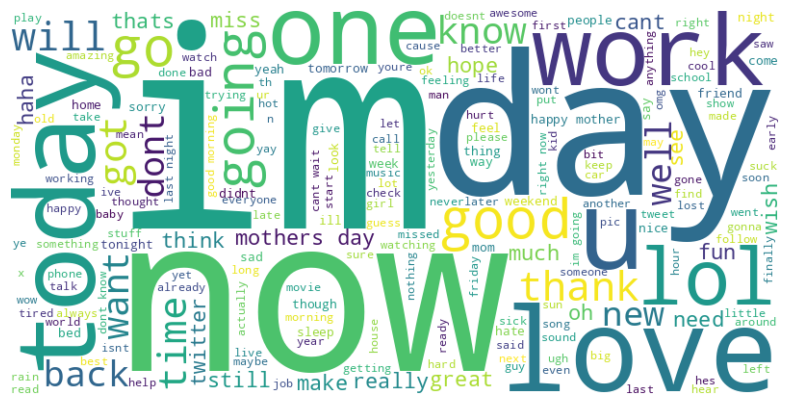

In [ ]:
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
import numpy as np

# Generate random indices for selecting 5 tweets
random_indices = np.random.choice(len(X_test), 5, replace=False)

print("Predictions for random 5 tweets:")
for i in random_indices:
    tweet = X_test.iloc[i]
    true_sentiment = y_test.iloc[i]
    tweet_vec = X_test_vec[i]  # Get the vectorized representation of the tweet

    # Reshape the vectorized tweet to a 2D array
    tweet_vec = tweet_vec.reshape(1, -1)

    # Make predictions
    pred_sentiment_hard = voting_clf_hard.predict(tweet_vec)
    pred_sentiment_soft = voting_clf_soft.predict(tweet_vec)

    print("\nTweet:", tweet)
    print("True Sentiment:", true_sentiment)
    print("Predicted Sentiment (Hard Voting):", pred_sentiment_hard[0])
    print("Predicted Sentiment (Soft Voting):", pred_sentiment_soft[0])

Predictions for random 5 tweets:

Tweet: happy mothers day mommy and grandma haha  ily
True Sentiment: positive
Predicted Sentiment (Hard Voting): positive
Predicted Sentiment (Soft Voting): positive

Tweet: ive just realised   followers yay  
True Sentiment: neutral
Predicted Sentiment (Hard Voting): positive
Predicted Sentiment (Soft Voting): positive

Tweet:  if yall say so i trust you on that one
True Sentiment: neutral
Predicted Sentiment (Hard Voting): neutral
Predicted Sentiment (Soft Voting): neutral

Tweet: had a wonderful evening with those i love
True Sentiment: positive
Predicted Sentiment (Hard Voting): positive
Predicted Sentiment (Soft Voting): positive

Tweet: allies not coming over
True Sentiment: neutral
Predicted Sentiment (Hard Voting): neutral
Predicted Sentiment (Soft Voting): neutral


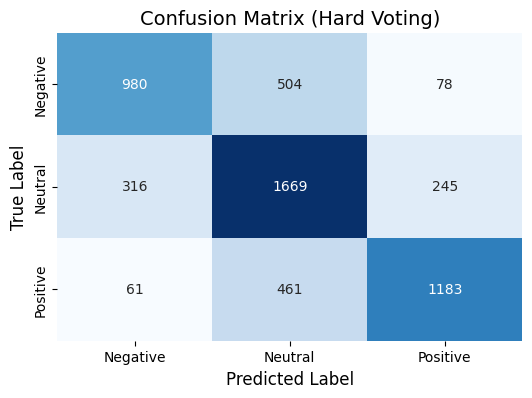

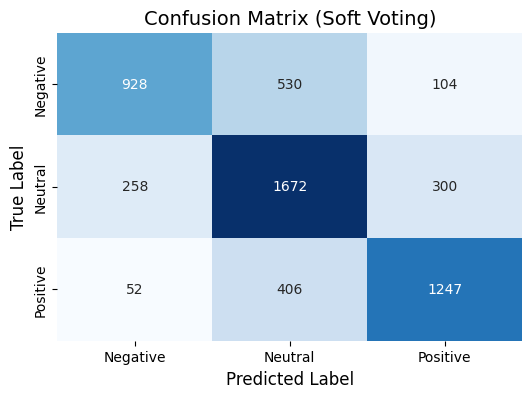

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(6, 4))  # Adjust figure size here
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False)  # Set cbar=False to remove color bar
    plt.title(title, fontsize=14)  # Adjust title font size
    plt.xlabel('Predicted Label', fontsize=12)  # Adjust x-axis label font size
    plt.ylabel('True Label', fontsize=12)  # Adjust y-axis label font size
    plt.xticks(fontsize=10)  # Adjust x-axis tick font size
    plt.yticks(fontsize=10)  # Adjust y-axis tick font size
    plt.show()

# Get predictions
pred_hard = voting_clf_hard.predict(X_test_vec)
pred_soft = voting_clf_soft.predict(X_test_vec)

# Calculate confusion matrix
cm_hard = confusion_matrix(y_test, pred_hard)
cm_soft = confusion_matrix(y_test, pred_soft)

# Plot confusion matrix for hard voting classifier
plot_confusion_matrix(cm_hard, classes=['Negative', 'Neutral', 'Positive'], title='Confusion Matrix (Hard Voting)')

# Plot confusion matrix for soft voting classifier
plot_confusion_matrix(cm_soft, classes=['Negative', 'Neutral', 'Positive'], title='Confusion Matrix (Soft Voting)')
